In [196]:
!python -V

Python 3.12.1


## Install packages.
With uv + vscode, there are two options (I went with first).
1. Add them to the project, cli: `uv add pandas` or jupyter: `!uv add pandas`
2. Install them, bypassing `pyproject.toml`. Jupyter: `!uv pip install pandas`

More in README.MD

In [197]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import root_mean_squared_error  # , mean_squared_error be

In [ ]:
df = pd.read_parquet("../data/green_tripdata_2021-01.parquet")

In [199]:
df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)

In [200]:
# get travel duration time, delta
df["duration"] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
# for each element in duration (td) apply {math}
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

In [201]:
# https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_green.pdf
# df = df[df.trip_type == 2] # unrequred

In [202]:
# Slght deviation from the lecture, we should do filtering before plotting in this case
df = df[((df.duration >= 1) & (df.duration <= 60))]

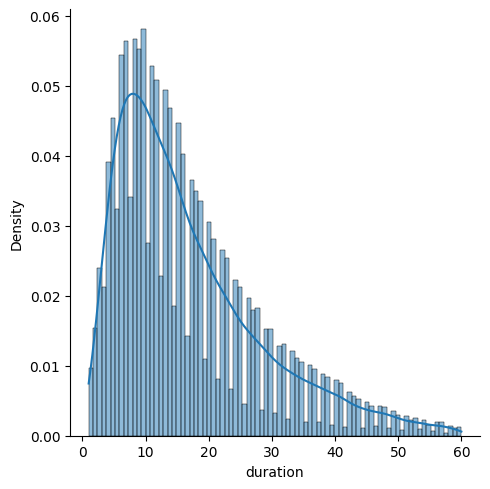

In [203]:
# dictplot is deprecated, general alternative is displot.

# Kernel density estimation (KDE) is enabled (smoothing of the graph)
# Density: how likely values to occur within a certain range (regions of data).
# Density is normalized, so you can compare distribution, unlike frequencies or counts.

# .set part is unnecessary, sometimes helps with readability
sns.displot(df.duration, kde=True, stat="density")  # .set(xlim=(0, 100),ylim=(0, 0.06))

In [204]:
# Checking percentile to see below which values most of our rides are
df.duration.describe(percentiles=[0.95, 0.98, 0.99])

count    73908.000000
mean        16.852578
std         11.563163
min          1.000000
50%         14.000000
95%         41.000000
98%         48.781000
99%         53.000000
max         60.000000
Name: duration, dtype: float64

In [ ]:
categorical = ["PULocationID", "DOLocationID"]
numerical = ["trip_distance"]

In [206]:
df[categorical] = df[categorical].astype(str)

In [ ]:
train_dict = df[categorical + numerical].to_dict(orient="records")

Notes:
## One-hot encoding

> Is a technique to convert categorical variables (like strings or IDs) into a format that can be provided to machine learning algorithms.

### How it works:
- For each unique value in a categorical column, a new column is created.
- In each row, the column corresponding to the value is set to 1, and all others are set to 0.

#### Example

Before:
| Color |
|-------|
| Red   |
| Blue  |
| Green |

After one-hot:

| Color=Red | Color=Green | Color=Blue |
|-----------|-------------|------------|
|     1     |      0      |     0      |
|     0     |      0      |     1      |
|     0     |      1      |     0      |

So, categorical data is represented numerically, ergo usable for most machine learning models.

## Matrix 
In this case each value of DOLocationID, PULocationID becomes a "column" which shows 0 or 1, each row is a ride. `trip_distance` remains unchanged,

After `DictVectorizer`, matrix will look like this:

| PULocationID=10 | PULocationID=15 | DOLocationID=20 | DOLocationID=30 | trip_distance |
|-----------------|-----------------|-----------------|-----------------|--------------|
|        1        |        0        |        1        |        0        |     2.5      |
|        0        |        1        |        0        |        1        |     1.2      |
|        1        |        0        |        0        |        1        |     3.8      |

Final matrix has as many columns as there are unique categorical values (from both columns) plus one column for each numerical feature.

In [208]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dict)

In [209]:
# converting col into numpy array.
# making it a target for learning.
target = "duration"
y_train = df[target].values

In [210]:
lr = LinearRegression()
lr.fit(X_train, y_train)  # makes it learn
y_pred = lr.predict(
    X_train
)  # we can predict on "any" data we give, y is not asked, because it asumes it from .fit

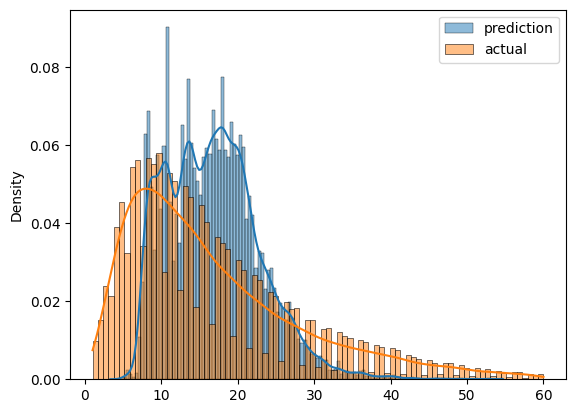

In [211]:
# dictplot is deprecated, for overlapping plots I found there are
# two alternatives: histplot and kdeplot. Kdeplot looks more informative

sns.histplot(
    y_pred, kde=True, stat="density", label="prediction", color="C0", alpha=0.5
)
sns.histplot(y_train, kde=True, stat="density", label="actual", color="C1", alpha=0.5)
plt.legend()  # render legend labels
plt.show()

In [212]:
# About using root_mean..., it's same as using mean_squared_error(squared=false)

# calc the wellness of prediction via comparison of train vs pred via formula (y_true - y_pred) ** 2
root_mean_squared_error(y_train, y_pred)
# Thought model is bad, prediction is off by 9 minutes on average

9.838799799829626

In [213]:
# refactor for function approach
def read_dataframe(filename):
    if filename.endswith(".csv"):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith(".parquet"):
        df = pd.read_parquet(filename)

    df["duration"] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ["PULocationID", "DOLocationID"]
    df[categorical] = df[categorical].astype(str)

    return df

In [ ]:
df_train = read_dataframe("../data/green_tripdata_2021-01.parquet")
df_val = read_dataframe("../data/green_tripdata_2021-02.parquet")

In [215]:
# This way model treat combined PU/DO as unique identifier
# I guess it helps the model to learn on specific patterns of PU/DO combination
df_train["PU_DO"] = df_train["PULocationID"] + "_" + df_train["DOLocationID"]
df_val["PU_DO"] = df_val["PULocationID"] + "_" + df_val["DOLocationID"]

training - january
validation - february

In [216]:
categorical = ["PU_DO"]  # combined 'PULocationID', 'DOLocationID'
numerical = ["trip_distance"]

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient="records")
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient="records")
X_val = dv.transform(val_dicts)

In [217]:
target = "duration"
y_train = df_train[target].values
y_val = df_val[target].values

In [218]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

root_mean_squared_error(y_val, y_pred)

7.758715209092169

In [219]:
# exporting the model
with open("../models/lin_reg.bin", "wb") as f_out:
    pickle.dump((dv, lr), f_out)

In [220]:
lr = Lasso(alpha=0.0001)  # Alpha uses the math concept of regularization
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

root_mean_squared_error(y_val, y_pred)

7.616617770546549